In [62]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer, AutoModel
from torchnlp.encoders import LabelEncoder
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [23]:
data_dir = "../../../data/twitter-distaster/"

In [24]:
train_df = pd.read_csv(f"{data_dir}/train.csv")
test_df = pd.read_csv(f"{data_dir}/test.csv")
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [25]:
val_df = train_df[51:70]
train_df = train_df[0:50]


In [26]:
val_df.shape

(19, 5)

<AxesSubplot:>

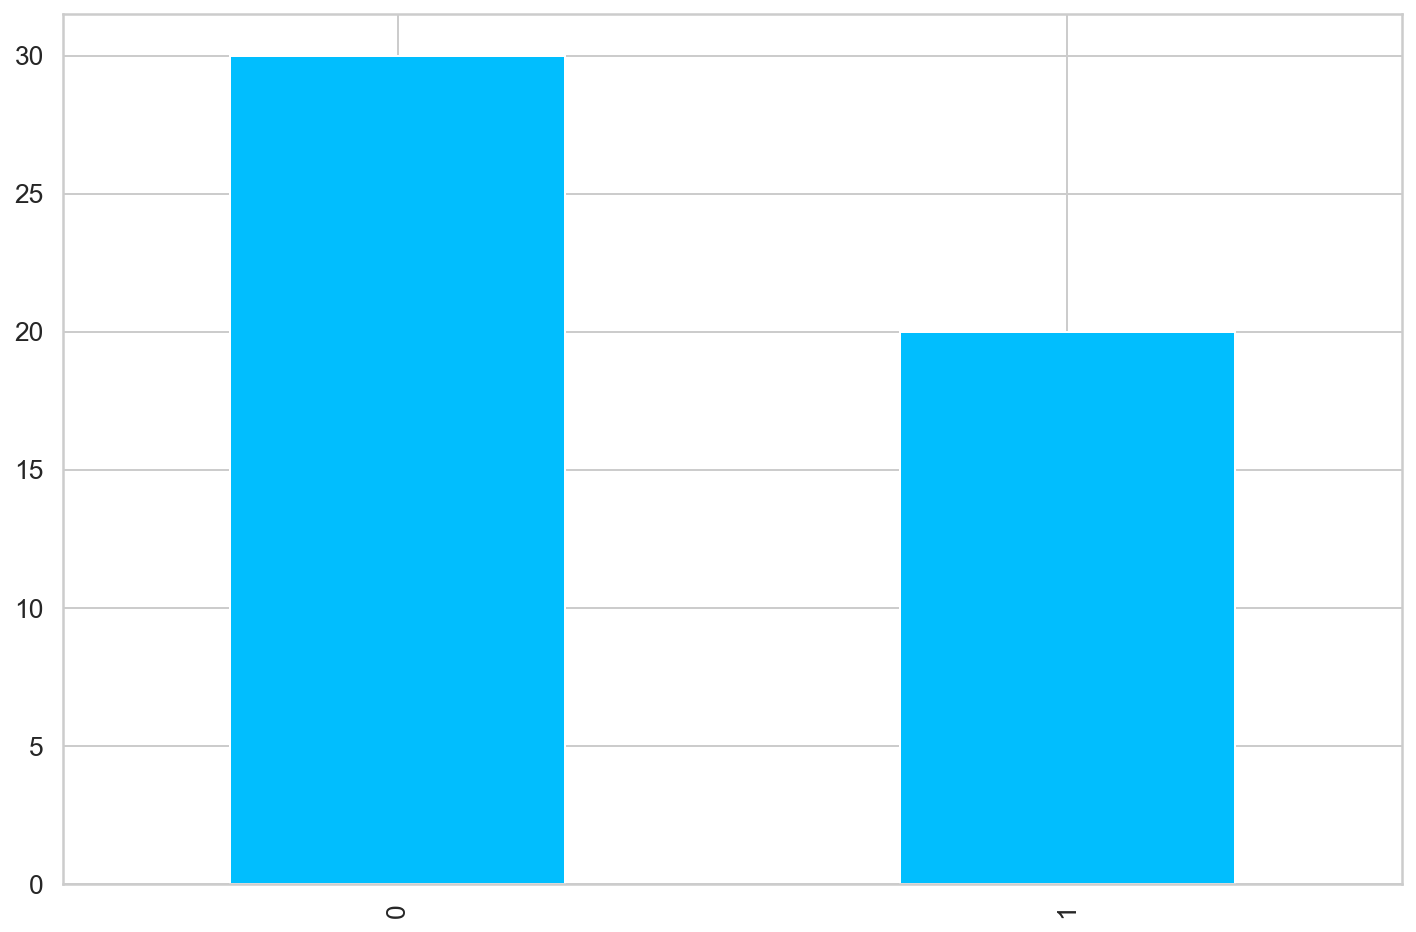

In [6]:
train_df.target.value_counts().plot(kind="bar")

In [27]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [28]:
class TwitterDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 512,
    text_col: str = "text",
    label_col: str = "target"
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    self.text_col = text_col
    self.label_col = label_col
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row[self.text_col]
    labels = data_row[self.label_col]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.tensor(labels)
    )

In [29]:
train_dataset = TwitterDataset(
  train_df,
  tokenizer,
  max_token_len=512
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [89]:
sample_item["comment_text"]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [90]:
sample_item["labels"]

tensor(1)

In [87]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [30]:
class TwitterDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=2, max_token_len=512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = TwitterDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = TwitterDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )

In [63]:
N_EPOCHS = 1
BATCH_SIZE = 2
MAX_TOKEN_COUNT = 512
data_module = TwitterDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [64]:
class TwitterClassifier(pl.LightningModule):

  def __init__(self, num_labels: int, n_training_steps=None, n_warmup_steps=None, reinit_n_layers = 0):
    super().__init__()

    self.save_hyperparameters()
    self.num_labels = num_labels
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.5,1.2]))

    self.reinit_n_layers = reinit_n_layers
    if reinit_n_layers > 0: self._do_reinit()  

  def _do_reinit(self):
      # Re-init pooler.
      self.bert.pooler.dense.weight.data.normal_(mean=0.0, std=self.bert.config.initializer_range)
      self.bert.pooler.dense.bias.data.zero_()
      for param in self.bert.pooler.parameters():
          param.requires_grad = True
      
      # Re-init last n layers.
      for n in range(self.reinit_n_layers):
          self.bert.encoder.layer[-(n+1)].apply(self._init_weight_and_bias)
          
  def _init_weight_and_bias(self, module):                        
      if isinstance(module, nn.Linear):
          module.weight.data.normal_(mean=0.0, std=self.bert.config.initializer_range)
          if module.bias is not None:
              module.bias.data.zero_()
      elif isinstance(module, nn.LayerNorm):
          module.bias.data.zero_()
          module.weight.data.fill_(1.0)      

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    last_hidden_state = output.last_hidden_state
    # As I said, the CLS token is in the beginning of the sequence. So, we grab its representation 
    # by indexing the tensor containing the hidden representations
    CLS_token_state = last_hidden_state[:, 0, :]
    output = self.classifier(CLS_token_state)
           
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def training_epoch_end(self, outputs):
    
    softmax = nn.functional.softmax
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        out_predictions = softmax(out_predictions, dim = -1)
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    class_roc_auc = auroc(predictions, labels, num_classes=self.num_labels)
    f1_score = f1(predictions,labels,average = "weighted", num_classes = self.num_labels)
    self.logger.experiment.add_scalar(f"roc_auc/Train", class_roc_auc, self.current_epoch)
    self.logger.experiment.add_scalar(f"f1_weighted/Train", f1_score, self.current_epoch)

  def validation_epoch_end(self, outputs):
    
    softmax = nn.functional.softmax
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        out_predictions = softmax(out_predictions, dim = -1)
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    class_roc_auc = auroc(predictions, labels, num_classes=self.num_labels)
    f1_score = f1(predictions,labels,average = "weighted", num_classes = self.num_labels)
    self.logger.experiment.add_scalar(f"roc_auc/Valid", class_roc_auc, self.current_epoch)
    self.logger.experiment.add_scalar(f"f1_weighted/Valid", f1_score, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [65]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [66]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(5, 25)

In [67]:
model = TwitterClassifier(
  num_labels=2,
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps, 
  reinit_n_layers= 2
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# model.configure_optimizers()

In [37]:
# optimizer = AdamW(model.parameters(), lr = 2e-5)
# optimizer

In [68]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints/twitterdisaster/"+"version_"+datetime.now().strftime("%d-%m-%Y--%H-%M"),
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [69]:
logger = TensorBoardLogger("lightning_logs", version ="version_"+datetime.now().strftime("%d-%m-%Y--%H-%M") ,name="twitter-disaster")

In [70]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [73]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS ,
  gpus=None, 
  accumulate_grad_batches=4
  
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\ntaylor\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [74]:
trainer.fit(model, data_module)


  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 109 M 
1 | classifier | Linear           | 1.5 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 35/35 [02:33<00:00,  4.39s/it, loss=0.258, v_num=3-47, val_loss=0.329, train_loss=0.269]

Epoch 0, global step 6: val_loss reached 0.32927 (best 0.32927), saving model to "C:\Users\ntaylor\Documents\GitHub\Neural_Networks\NLP_Mimic_only\pytorch-lightning-models\checkpoints\twitterdisaster\version_11-11-2021--13-47\best-checkpoint.ckpt" as top 1


Epoch 0: 100%|██████████| 35/35 [03:07<00:00,  5.37s/it, loss=0.258, v_num=3-47, val_loss=0.329, train_loss=0.269]


1

In [53]:
trainer.test(ckpt_path="best")

Testing: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.22611144185066223}
--------------------------------------------------------------------------------


[{'test_loss': 0.22611144185066223}]

In [33]:
ckpt_dir = "./checkpoints/twitterdisaster/"
trained_model = TwitterClassifier.load_from_checkpoint(
  f"{ckpt_dir}best-checkpoint-v4.ckpt", map_location="cpu"
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
test_comment = "Wind blowing. Danger coming"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = nn.functional.softmax(test_prediction, dim = 1)
test_prediction = test_prediction.flatten().numpy()
np.argmax(test_prediction, axis = 0)
LABEL_COLUMNS = ["real","fake"]
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

real: 0.532301664352417
fake: 0.4676983654499054


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TwitterDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  prediction = nn.functional.softmax(prediction, dim = 1)
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

100%|██████████| 19/19 [00:01<00:00, 15.99it/s]


In [36]:
accuracy(predictions, labels)

tensor(0.6316)

In [40]:
labels

tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1],
       dtype=torch.int32)

In [35]:
inst_auroc = auroc(predictions, labels, num_classes = 2)
inst_auroc

tensor(0.7667)

In [54]:
predictions.shape

torch.Size([19, 2])

In [38]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.argmax(y_pred,axis=1)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=["real","fake"], 
  zero_division=0
))

              precision    recall  f1-score   support

        real       0.71      0.50      0.59        10
        fake       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



In [39]:
y_pred

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1],
      dtype=int64)